## LSTM (complex implementation)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arch.bootstrap as bootstrap
from numpy.random import RandomState
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics
import tensorflow as tf
import os
import random
from keras import backend

2023-05-31 11:55:01.416558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 11:55:01.602767: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-31 11:55:01.602791: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-31 11:55:02.642953: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# eliminate randomness for reproducability
seed_value = 42

# Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

In [3]:
# prepare data for LSTM train/test sets
df_ts = pd.read_csv("DF_TS.csv")
df_LSTM = df_ts[['daily_vol', 'mean_polarity_vader']]
upper_bound_vol = df_LSTM['daily_vol'].quantile(q=0.95)
df_LSTM['daily_vol'] = df_LSTM['daily_vol'].clip(0, upper_bound_vol)
df_LSTM['mean_polarity_vader'] = abs(df_LSTM['mean_polarity_vader'])

/tmp/ipykernel_102303/3143220735.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LSTM['daily_vol'] = df_LSTM['daily_vol'].clip(0, upper_bound_vol)
/tmp/ipykernel_102303/3143220735.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LSTM['mean_polarity_vader'] = abs(df_LSTM['mean_polarity_vader'])


In [4]:
seq_len = 15

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    #print(sequences)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, 0]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, 0]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(df_LSTM, seq_len, train_frac=0.9)


In [5]:
# fraction of the input to drop; helps prevent overfitting
dropout = 0.1
window_size = seq_len - 1

# build a multi-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(units=3, return_sequences=True, 
         input_shape=(x_train.shape[1], x_train.shape[-1]))
)

# Bidirectional allows for training of sequence data forwards and backwards
model.add(
    Bidirectional(LSTM(units=3, return_sequences=True))
)
model.add(Dropout(rate=dropout))

model.add(
    LSTM(units=4, return_sequences=True)
)

model.add(
    LSTM(units=6, return_sequences=True)
)

model.add(
    LSTM(units=2, return_sequences=True)
)

model.add(Dropout(rate=dropout))

model.add(
    LSTM(units=1, return_sequences=False)
)

# ReLU activation function as we will have a positive output
model.add(Activation('ReLU'))

2023-05-31 11:55:04.850309: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-31 11:55:04.850341: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-31 11:55:04.850365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tuomas-Lenovo): /proc/driver/nvidia/version does not exist
2023-05-31 11:55:04.850643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
batch_size = 256

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

Epoch 1/20
3/3 [==============================] - 20s 2s/step - loss: 9.8328e-06 - val_loss: 4.4235e-06
Epoch 2/20
3/3 [==============================] - 0s 63ms/step - loss: 6.3390e-06 - val_loss: 3.8911e-06
Epoch 3/20
3/3 [==============================] - 0s 63ms/step - loss: 5.8604e-06 - val_loss: 2.9720e-06
Epoch 4/20
3/3 [==============================] - 0s 63ms/step - loss: 5.6230e-06 - val_loss: 3.0069e-06
Epoch 5/20
3/3 [==============================] - 0s 67ms/step - loss: 6.0441e-06 - val_loss: 2.5066e-06
Epoch 6/20
3/3 [==============================] - 0s 65ms/step - loss: 4.9804e-06 - val_loss: 3.2711e-06
Epoch 7/20
3/3 [==============================] - 0s 67ms/step - loss: 5.4210e-06 - val_loss: 2.5086e-06
Epoch 8/20
3/3 [==============================] - 0s 65ms/step - loss: 5.3169e-06 - val_loss: 2.6235e-06
Epoch 9/20
3/3 [==============================] - 0s 63ms/step - loss: 5.4417e-06 - val_loss: 2.5796e-06
Epoch 10/20
3/3 [==============================] - 0s 63

3/3 [==============================] - 3s 11ms/step


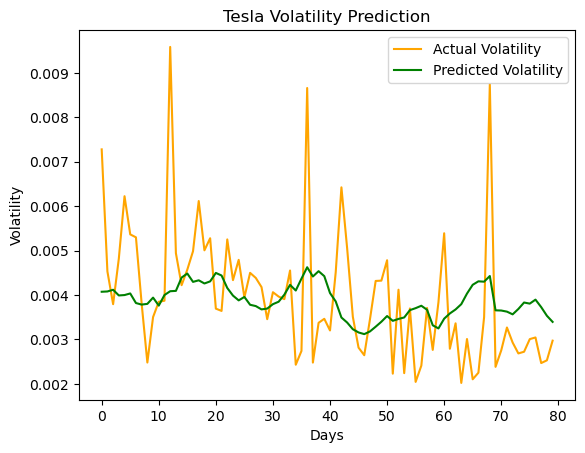

In [7]:
y_pred = model.predict(x_test)
# plots of prediction against actual data
plt.plot(y_test, label='Actual Volatility', color='orange')
plt.plot(y_pred, label='Predicted Volatility', color='green')
 
plt.title('Tesla Volatility Prediction')
plt.xlabel('Days')
plt.ylabel('Volatility')
plt.legend(loc='best')

plt.show()

In [8]:
rsquared_oos_lstm = metrics.r2_score(y_test, y_pred)
print("The out-of-sample R^2 for LSTM is: {:.4f}".format(rsquared_oos_lstm))

The out-of-sample R^2 for LSTM is: 0.0859


23/23 [==============================] - 0s 9ms/step


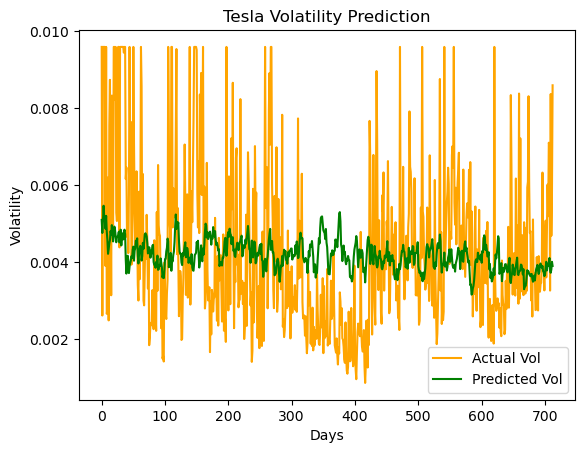

In [9]:
y_pred_train = model.predict(x_train)

# plots of prediction against actual data
plt.plot(y_train, label='Actual Vol', color='orange')
plt.plot(y_pred_train, label='Predicted Vol', color='green')
 
plt.title('Tesla Volatility Prediction')
plt.xlabel('Days')
plt.ylabel('Volatility')
plt.legend(loc='best')

plt.show();

In [10]:
rsquared_is_lstm = metrics.r2_score(y_train, y_pred_train)
print("The in-sample R^2 for LSTM is: {:.4f}".format(rsquared_is_lstm))

The in-sample R^2 for LSTM is: 0.0117


## Using bootstrapping

In [11]:
# for reproducibility
rs = RandomState(1)
opti_len = bootstrap.optimal_block_length(df_LSTM)
# we use the optimal length for the volatility
bs = bootstrap.StationaryBootstrap(opti_len['stationary'].iloc[0], df_LSTM, random_state=rs)

bootstrapping_length = 9
y_avg = y_pred / (1 + bootstrapping_length)
for data in bs.bootstrap(bootstrapping_length):
    temp_df = data[0][0]
    x_train_temp, y_train_temp, x_test_temp, y_test_temp = get_train_test_sets(temp_df, seq_len, train_frac=0.9)
    # model.fit 
    history = model.fit(
        x_train_temp,
        y_train_temp,
        epochs=20,
        batch_size=batch_size,
        shuffle=False,
        validation_split=0.2
    )
    # use the original test set, latest fraction of the samples to test the model
    y_pred_temp = model.predict(x_test)
    y_avg += y_pred_temp / (1 + bootstrapping_length)

Epoch 1/20
3/3 [==============================] - ETA: 0s - loss: 5.5177e-06

/home/tuomasp/anaconda3/lib/python3.9/site-packages/arch/bootstrap/base.py:414: FutureWarning: random_state is deprecated and will be removed in a future version. The default random number generator is changing to a NumPy Generator. To continue using RandomState, please directly pass a RandomState instance using the ``generator`` keyword argument.
  warnings.warn(


3/3 [==============================] - 0s 71ms/step - loss: 5.5177e-06 - val_loss: 2.7159e-06
Epoch 2/20
3/3 [==============================] - 0s 43ms/step - loss: 5.3076e-06 - val_loss: 2.7263e-06
Epoch 3/20
3/3 [==============================] - 0s 46ms/step - loss: 5.3782e-06 - val_loss: 2.7614e-06
Epoch 4/20
3/3 [==============================] - 0s 44ms/step - loss: 5.3497e-06 - val_loss: 2.7619e-06
Epoch 5/20
3/3 [==============================] - 0s 48ms/step - loss: 5.5434e-06 - val_loss: 2.7260e-06
Epoch 6/20
3/3 [==============================] - 0s 50ms/step - loss: 5.3447e-06 - val_loss: 2.7153e-06
Epoch 7/20
3/3 [==============================] - 0s 43ms/step - loss: 5.4980e-06 - val_loss: 2.7380e-06
Epoch 8/20
3/3 [==============================] - 0s 44ms/step - loss: 5.3363e-06 - val_loss: 2.7239e-06
Epoch 9/20
3/3 [==============================] - 0s 48ms/step - loss: 5.3856e-06 - val_loss: 2.7436e-06
Epoch 10/20
3/3 [==============================] - 0s 43ms/step - 

Epoch 13/20
3/3 [==============================] - 1s 273ms/step - loss: 4.0085e-06 - val_loss: 3.6711e-06
Epoch 14/20
3/3 [==============================] - 1s 268ms/step - loss: 3.9824e-06 - val_loss: 3.6446e-06
Epoch 15/20
3/3 [==============================] - 1s 272ms/step - loss: 3.9694e-06 - val_loss: 3.6946e-06
Epoch 16/20
3/3 [==============================] - 1s 295ms/step - loss: 4.0073e-06 - val_loss: 3.7136e-06
Epoch 17/20
3/3 [==============================] - 1s 306ms/step - loss: 3.9606e-06 - val_loss: 3.6610e-06
Epoch 18/20
3/3 [==============================] - 1s 307ms/step - loss: 4.0062e-06 - val_loss: 3.6940e-06
Epoch 19/20
3/3 [==============================] - 1s 274ms/step - loss: 3.9477e-06 - val_loss: 3.7016e-06
Epoch 20/20
3/3 [==============================] - 0s 49ms/step
Epoch 1/20
3/3 [==============================] - 1s 438ms/step - loss: 4.6027e-06 - val_loss: 2.7834e-06
Epoch 2/20
3/3 [==============================] - 1s 298ms/step - loss: 4.5849e-0

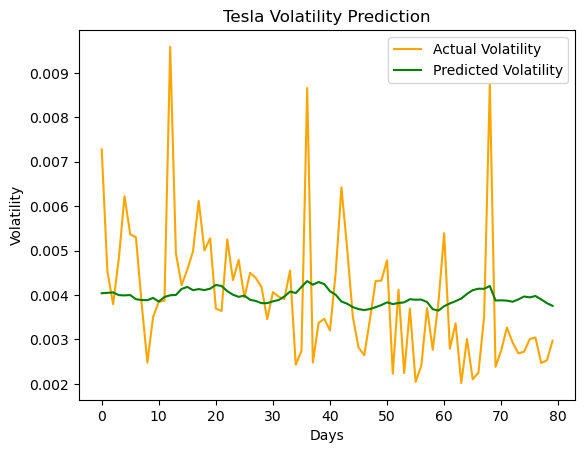

In [12]:
# plots of prediction against actual data
plt.plot(y_test, label='Actual Volatility', color='orange')
plt.plot(y_avg, label='Predicted Volatility', color='green')

plt.title('Tesla Volatility Prediction')
plt.xlabel('Days')
plt.ylabel('Volatility')
plt.legend(loc='best')

plt.show()

In [13]:
rsquared_oos_lstm_b = metrics.r2_score(y_test, y_avg)
print("The out-of-sample R^2 for LSTM, with bootstrapping, is: {:.4f}".format(rsquared_oos_lstm_b))

The out-of-sample R^2 for LSTM, with bootstrapping, is: 0.0471
